Data Science Internship at Zeotap- Task3

C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


DB Index: 1.3710672065076628
Silhouette Score: 0.2060501666722203


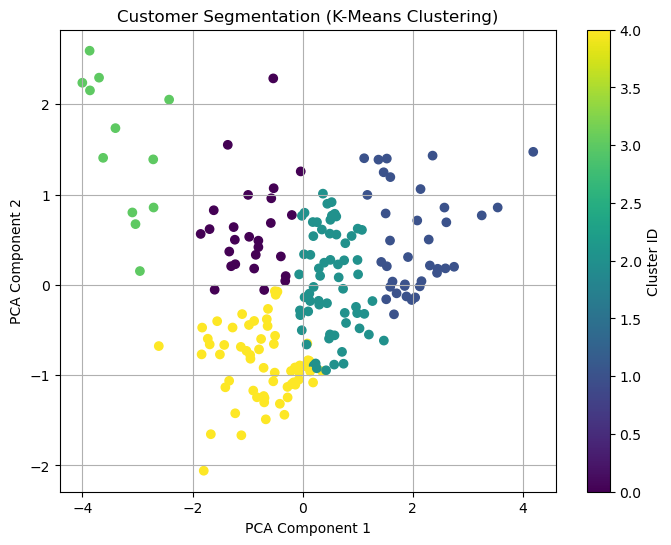

In [8]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# Loading the datasets
customers_df = pd.read_csv(r"C:\Users\91996\Downloads\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\91996\Downloads\Transactions - Transactions.csv")

# Ensuring that date format is maintained
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
today = datetime.today()

# Recency (Days since last transaction)
recency_df = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()

# Calculate Recency as the difference from today (current date)
recency_df['Recency'] = (today - recency_df['TransactionDate']).dt.days

# Cliping the negative values if any we get during the calculation
recency_df['Recency'] = recency_df['Recency'].clip(lower=0)

# Frequency (Number of transactions per customer)
frequency_df = transactions_df.groupby('CustomerID')['TransactionID'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']

# Clip negative frequency values if any we get during the calculation
frequency_df['Frequency'] = frequency_df['Frequency'].clip(lower=0)

# Monetary (Total value of transactions per customer)
monetary_df = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

# Clip negative monetary values if any we get druing the calculation
monetary_df['Monetary'] = monetary_df['Monetary'].clip(lower=0)

# Merging RFM features with customers data
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
customer_features_df = customers_df[['CustomerID', 'Region']].merge(rfm_df, on='CustomerID')

# One-hot encode 'Region' feature (assuming 'Region' is categorical)
region_encoded = pd.get_dummies(customer_features_df['Region'], prefix='Region')
customer_features_df = pd.concat([customer_features_df, region_encoded], axis=1).drop(columns=['Region'])

customer_features_df = customer_features_df.drop(columns=['SignupDate', 'TransactionDate'], errors='ignore')

# Standardizing the numerical features 
scaler = StandardScaler()
rfm_features = customer_features_df[['Recency', 'Frequency', 'Monetary']]
scaled_rfm = scaler.fit_transform(rfm_features)
scaled_rfm_df = pd.DataFrame(scaled_rfm, columns=['Recency', 'Frequency', 'Monetary'])
customer_features_df[['Recency', 'Frequency', 'Monetary']] = scaled_rfm_df

# Final dataset for clustering 
final_features_df = customer_features_df.drop(columns=['CustomerID'])

# Perform clustering (considering 5 clusters)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(final_features_df)

customer_features_df['Cluster'] = clusters

# Evaluate clustering with Davies-Bouldin Index and Silhouette Score
db_index = davies_bouldin_score(final_features_df, clusters)
silhouette = silhouette_score(final_features_df, clusters)

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

# Visualize the clusters using PCA 
pca = PCA(n_components=2)
pca_components = pca.fit_transform(final_features_df)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_features_df['Cluster'], cmap='viridis', marker='o')
plt.title('Customer Segmentation (K-Means Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


Using DBSCAN clustering method to compare the values in comparison to K-Mean clustering

DB Index: 1.805635539408861
Silhouette Score: -0.1627528466993629


C:\Users\91996\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


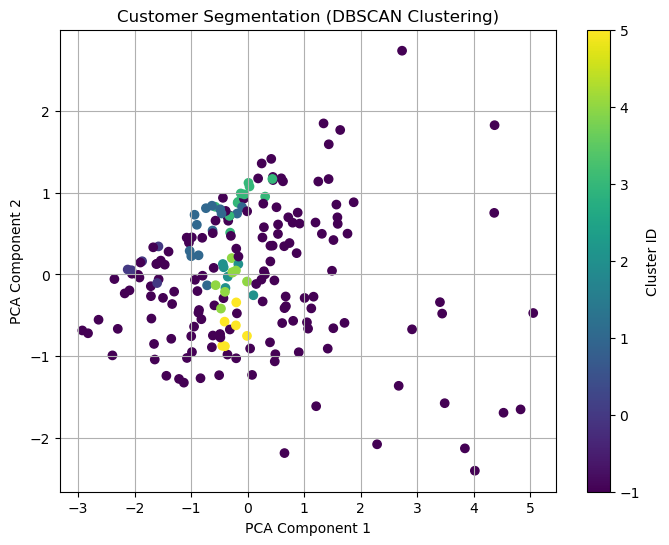

In [10]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Loading the datasets
customers_df = pd.read_csv(r"C:\Users\91996\Downloads\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\91996\Downloads\Transactions - Transactions.csv")

# Ensuring that date format is maintained
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
today = datetime.today()

# Recency (Days since last transaction)
recency_df = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (today - recency_df['TransactionDate']).dt.days
recency_df['Recency'] = recency_df['Recency'].clip(lower=0)

# Frequency (Number of transactions per customer)
frequency_df = transactions_df.groupby('CustomerID')['TransactionID'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df['Frequency'] = frequency_df['Frequency'].clip(lower=0)

# Monetary (Total value of transactions per customer)
monetary_df = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df['Monetary'] = monetary_df['Monetary'].clip(lower=0)

# Merging RFM features with customers data
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
customer_features_df = customers_df[['CustomerID', 'Region']].merge(rfm_df, on='CustomerID')

encoder = OneHotEncoder(sparse=False)
region_encoded = encoder.fit_transform(customer_features_df[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.categories_[0], index=customer_features_df.index)
customer_features_df = pd.concat([customer_features_df, region_encoded_df], axis=1).drop(columns=['Region'])

customer_features_df = customer_features_df.drop(columns=['SignupDate', 'TransactionDate'], errors='ignore')

# log(x+1) to avoid issues with zeros
customer_features_df['Monetary'] = np.log1p(customer_features_df['Monetary'])

# Standardizing the numerical features
scaler = StandardScaler()
rfm_features = customer_features_df[['Recency', 'Frequency', 'Monetary']]
scaled_rfm = scaler.fit_transform(rfm_features)
scaled_rfm_df = pd.DataFrame(scaled_rfm, columns=['Recency', 'Frequency', 'Monetary'])
customer_features_df[['Recency', 'Frequency', 'Monetary']] = scaled_rfm_df

final_features_df = customer_features_df.drop(columns=['CustomerID'])

# Perform clustering with DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(final_features_df)


customer_features_df['Cluster'] = clusters

# Evaluate clustering with Davies-Bouldin Index and Silhouette Score
db_index = davies_bouldin_score(final_features_df, clusters)
silhouette = silhouette_score(final_features_df, clusters)

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

# Visualize the clusters using PCA 
pca = PCA(n_components=2)
pca_components = pca.fit_transform(final_features_df)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_features_df['Cluster'], cmap='viridis', marker='o')
plt.title('Customer Segmentation (DBSCAN Clustering)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


Now we came to know that DBSCAN method do not provide the accurate and desired answer as compared to K-Mean.
So now to get the optimal scores using K-Mean clustering algorithm we try to find the optimal clusters value as in the above method we used 5 as the base value but now we will try to find the most optimal cluster value to get the desired score .

The optimal value for Davies-Bouldin Index (DB Index) [below 1 is excellent]
The optimal value for Silhouette Score : In range of [-1,1], higher the value better it is

C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

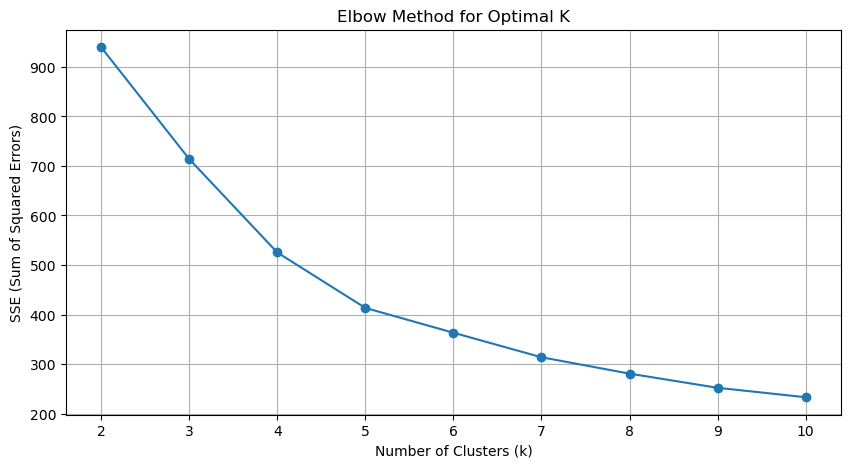

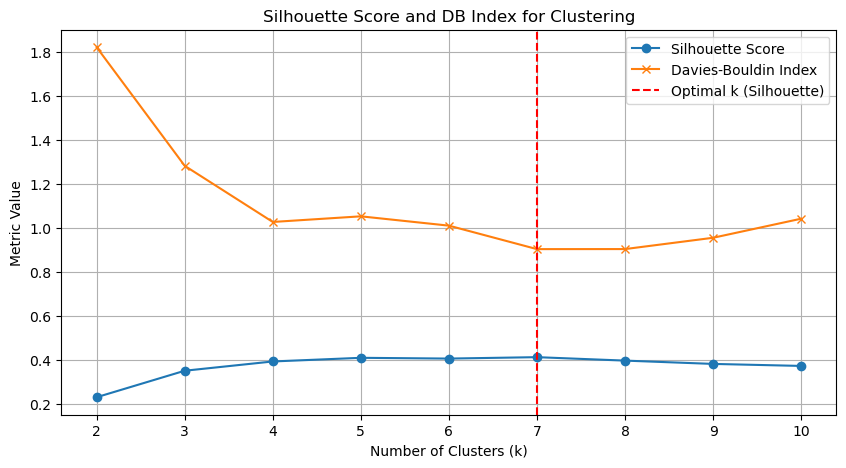

Optimal number of clusters: 7


C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\91996\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Final DB Index: 0.9050463918169386
Final Silhouette Score: 0.4137902511414214


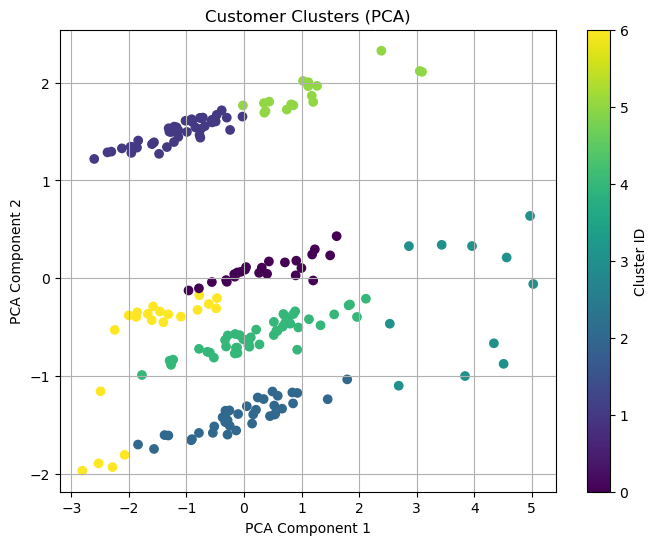

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

# Loading the datasets
customers_df = pd.read_csv(r"C:\Users\91996\Downloads\Customers.csv")
transactions_df = pd.read_csv(r"C:\Users\91996\Downloads\Transactions - Transactions.csv")

# Ensuring that date format is maintained
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
today = datetime.today()

# RFM features
recency_df = transactions_df.groupby('CustomerID')['TransactionDate'].max().reset_index()
recency_df['Recency'] = (today - recency_df['TransactionDate']).dt.days
frequency_df = transactions_df.groupby('CustomerID')['TransactionID'].nunique().reset_index()
frequency_df.columns = ['CustomerID', 'Frequency']
monetary_df = transactions_df.groupby('CustomerID')['TotalValue'].sum().reset_index()
monetary_df.columns = ['CustomerID', 'Monetary']

# Merging RFM with customers data
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')
customer_features_df = customers_df[['CustomerID', 'Region']].merge(rfm_df, on='CustomerID')

# One-hot encode regions
customer_features_df = pd.get_dummies(customer_features_df, columns=['Region'], drop_first=True)

# Log-transform monetary to reduce skewness
customer_features_df['Monetary'] = np.log1p(customer_features_df['Monetary'])

numeric_features_df = customer_features_df.drop(columns=['CustomerID'], errors='ignore')
numeric_features_df = numeric_features_df.select_dtypes(exclude=['datetime64[ns]', 'object'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_features_df)

# Finding optimal number of clusters (Elbow Method and Silhouette Score)
sse = []
silhouette_scores = []
db_indices = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
    sse.append(kmeans.inertia_)  # Sum of Squared Errors
    silhouette_scores.append(silhouette_score(scaled_features, clusters))
    db_indices.append(davies_bouldin_score(scaled_features, clusters))

# Elbow Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, sse, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.grid()
plt.show()

# Silhouette and DB Index Plot
plt.figure(figsize=(10, 5))
plt.plot(k_values, silhouette_scores, marker='o', label="Silhouette Score")
plt.plot(k_values, db_indices, marker='x', label="Davies-Bouldin Index")
plt.axvline(x=silhouette_scores.index(max(silhouette_scores)) + 2, color='r', linestyle='--', label='Optimal k (Silhouette)')
plt.title("Silhouette Score and DB Index for Clustering")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Metric Value")
plt.legend()
plt.grid()
plt.show()

# Optimal k (based on silhouette score)
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Optimal number of clusters: {optimal_k}")

# Final KMeans with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_clusters = kmeans.fit_predict(scaled_features)
customer_features_df['Cluster'] = final_clusters

# Evaluate Final Clustering
final_db_index = davies_bouldin_score(scaled_features, final_clusters)
final_silhouette = silhouette_score(scaled_features, final_clusters)
print(f"Final DB Index: {final_db_index}")
print(f"Final Silhouette Score: {final_silhouette}")

# PCA Visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=customer_features_df['Cluster'], cmap='viridis')
plt.title('Customer Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.grid()
plt.show()


Hence at last we can find that the best algorithm suited here is K-Mean clustering and with the cluster value 7 the scores of DB index and Silhouette score is the most optimal we can get.
DB Index:0.9050463918169386
Silhouette Score: 0.4137902511414214